# Assignment 3
## 1: `git` in practice

Link to this repository: [astr8004_assign3](https://github.com/cyb0rb/astr8004_assign3)

## 2: Using ADQL to search for bright stars around the open cluster M67


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.table import Table
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d

In [3]:
from astroquery.gaia import Gaia

Data needed for this assignment:
- `ra, dec` for angular separation (and can plot them)
- `parallax` from GAIA (used to calc distance -> abs magnitude)
- `bp_rp` from GAIA (BP - RP)
- `phot_g_mean_mag` from GAIA (used to calc absolute magnitude)
- `distance_gspphot` maybe? this is a distance
- `j_m` from 2MASS (j magnitude)
- `ks_m` from 2MASS (k magnitude)
- `ph_qual` from 2MASS (quality check)

Using [this source on the GAIA site](https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries) for help writing queries and my partner (data scientist) for explaining how these `JOIN`s work.

Query:
- `SELECT ...` get column data from all stars
- `FROM gaiadr3.gaia_source AS gaia` from the Gaia DR3 catalog specifically
- `JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)` only use rows(stars) that are also in 2MASS 
- `JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)` with the JOIN below, connects the DR3 sources to the corresponding TMASS ones
- `JOIN gaiadr1.tmass_original_valid AS tmass ON xjoin.original_psc_source_id = tmass.designation`
- `WHERE DISTANCE(POINT(132.825,11.8), POINT(gaia.ra, gaia.dec)) < 1.` within 1 degree of the center of M67
- `AND gaia.phot_g_mean_mag < 14` brighter than G=14

In [4]:
# ADQL query
query = f"""
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.distance_gspphot, tmass.ph_qual, tmass.j_m, tmass.ks_m
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON xjoin.original_psc_source_id = tmass.designation
WHERE DISTANCE(POINT(132.825,11.8), POINT(gaia.ra, gaia.dec)) < 1.
AND gaia.phot_g_mean_mag < 14
"""

In [5]:
# Upload the source_id table for crossmatching
job = Gaia.launch_job_async(query=query)
gaiadr3_match = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [6]:
print(f"Initial number of stars (rows) returned from query: {len(gaiadr3_match)}")

# get rid of stars that don't have ph_qual = AAA
low_quality = gaiadr3_match[gaiadr3_match['ph_qual'] != 'AAA']
print(f"Stars with low quality data: {len(low_quality)}")

# get rid of stars that have negative parallax
negative_parallax = gaiadr3_match[gaiadr3_match['parallax'] < 0]
print(f"Stars with negative parallax: {len(negative_parallax)}")

# # clean data
# # (this also removed the negative parallax columns)
gaia_clean = gaiadr3_match[gaiadr3_match['parallax'] > 0]
print(f"Cleaned stars (all parallax > 0): {len(gaia_clean)}")

gaia_clean = gaia_clean[gaia_clean['ph_qual'] == 'AAA']
print(f"Cleaned stars (all ph_qual = AAA): {len(gaia_clean)}")

Initial number of stars (rows) returned from query: 1018
Stars with low quality data: 21
Stars with negative parallax: 2
Cleaned stars (all parallax > 0): 1009
Cleaned stars (all ph_qual = AAA): 988


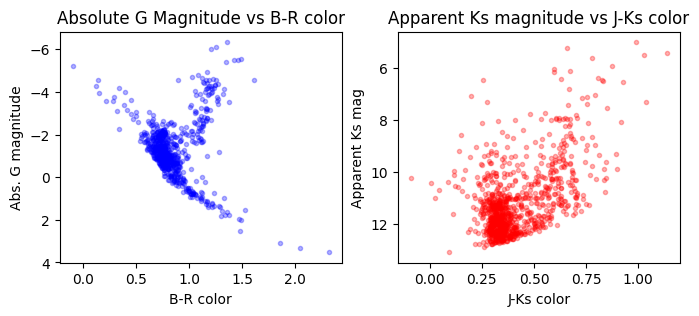

<Figure size 640x480 with 0 Axes>

In [42]:
# create plots
fig, ax = plt.subplots(1, 2, figsize=(8,3))

# absolute g magnitude: Mg = m - 5log(d)
abs_g = gaia_clean['phot_g_mean_mag'] - 5*np.log10(gaia_clean['distance_gspphot'])
j_k = gaia_clean['j_m'] - gaia_clean['ks_m']

# using normal scatterplot
ax[0].plot(gaia_clean['bp_rp'], abs_g, ".b", alpha=0.3)
ax[1].plot(j_k, gaia_clean['ks_m'], ".r", alpha=0.3)

# using 2d hist to plot
# h = ax[0].hist2d(gaia_clean['bp_rp'], abs_g, norm=colors.LogNorm(),
#     bins=(np.arange(min(gaia_clean['bp_rp']), max(gaia_clean['bp_rp']), 0.1), np.arange(min(abs_g), max(abs_g), 0.2)))
# plt.colorbar(h[3], ax=ax[0], label="Particle density", shrink=0.9)

# h = ax[1].hist2d(j_k, gaia_clean['ks_m'], norm=colors.LogNorm(),
#     bins=(np.arange(min(j_k), max(j_k), 0.05), np.arange(min(gaia_clean['ks_m']), max(gaia_clean['ks_m']), 0.2)))
# plt.colorbar(h[3], ax=ax[1], label="Particle density", shrink=0.9)

# labels
ax[0].yaxis.set_inverted(True)
ax[0].set(title="Absolute G Magnitude vs B-R color", xlabel="B-R color", ylabel="Abs. G magnitude")

ax[1].yaxis.set_inverted(True)
ax[1].set(title="Apparent Ks magnitude vs J-Ks color", xlabel="J-Ks color", ylabel="Apparent Ks mag")

plt.show()
plt.tight_layout()
fig.savefig("figures/cmds_M67.png", dpi=200)

### My Recommendation
According to the [2dF observation manual](https://aat.anu.edu.au/files/2dF-AAOmega-obs-manual_3.pdf), the 2dF fibre positioner and HERMES spectrograph can obtain spectra from 392 objects simultaneously, within a field of 2 degrees. Efficient fibre usage requires choosing at least 392 targets, and the sample of viable stars in the proposed 1-degree region around M67 is more than enough to satisfy that requirement with around 990 bright stars to choose from. The accompanying color-magnitude diagrams show the variety of stars within the field that could be observed.

## 3: Radial metallicity relation in simulated data

In [3]:
# load and get data from file
datafile = "data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits"    
data = Table.read(datafile)
print(data.info)

# radius
radius = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

<Table length=511520>
name  dtype 
---- -------
   x float32
   y float32
   z float32
 A_O float64



In [4]:
# fit linear function to data
def linear(x, a, b):
    return a*x + b

params, pcov = curve_fit(linear, radius, data['A_O'])
uncertainty = np.sqrt(np.diag(pcov))

print(f"Slope: {params[0]:.6f} ± {uncertainty[0]:.6f}")
print(f"Intercept: {params[1]:.5f} ± {uncertainty[1]:.5f}")

fit_data = linear(radius, *params)
residuals = data["A_O"] - fit_data

Slope: -0.033250 ± 0.000018
Intercept: 9.12232 ± 0.00028


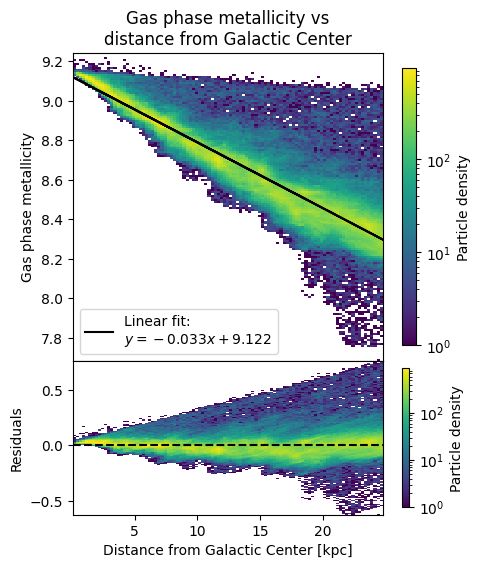

In [120]:
# plotting with a histogram instead
gridspec = {'height_ratios': [2,1]}
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw=gridspec, figsize=(5,6))
fig.subplots_adjust(hspace=0)

# radius vs metallicity
h = ax1.hist2d(radius, data['A_O'], norm=colors.LogNorm(),
    bins=(np.arange(min(radius), max(radius), 0.25), np.arange(min(data['A_O']), max(data['A_O']), 0.01)))
ax1.plot(radius, fit_data, "-k", 
    label=f"Linear fit:\n$y={params[0]:.3f}x + {params[1]:.3f}$")
plt.colorbar(h[3], ax=ax1, label="Particle density", shrink=0.9)


# residuals
h = ax2.hist2d(radius, residuals, norm=colors.LogNorm(),
    bins=(np.arange(min(radius), max(radius), 0.25), np.arange(min(residuals), max(residuals), 0.01)))
ax2.axhline(y=0, color="black", linestyle="--")
plt.colorbar(h[3], ax=ax2, label="Particle density", shrink=0.9)

# labels
ax1.set(
    ylabel = "Gas phase metallicity",
    title  = "Gas phase metallicity vs\ndistance from Galactic Center"
)
ax2.set(
    xlabel = "Distance from Galactic Center [kpc]",
    ylabel = "Residuals"
)
ax1.legend(loc="lower left")

# save

# plt.tight_layout()
fig.savefig("figures/metallicity_histogram.png")
plt.show()

### Discussion here
the linear model fits best at closer distances (<10 kpc or so), and beyond that it underestimates the metallicity.

In [98]:
# create histograms based on medians
# median simulated A_O
binstat_median, median_xedges, median_yedges, median_binnum = binned_statistic_2d(data['x'], data['y'], fit_data, statistic='median', bins=70)

# median fitted A_O
binstat_med_data, med_data_xedges, med_data_yedges, med_data_binnum = binned_statistic_2d(data['x'], data['y'], data['A_O'],  statistic='median', bins=70)

# median of A_0 residual fit
binstat_med_resids, med_resids_xedges, med_resids_yedges, med_resids_binnum = binned_statistic_2d(data['x'], data['y'], residuals, statistic='median', bins=70)

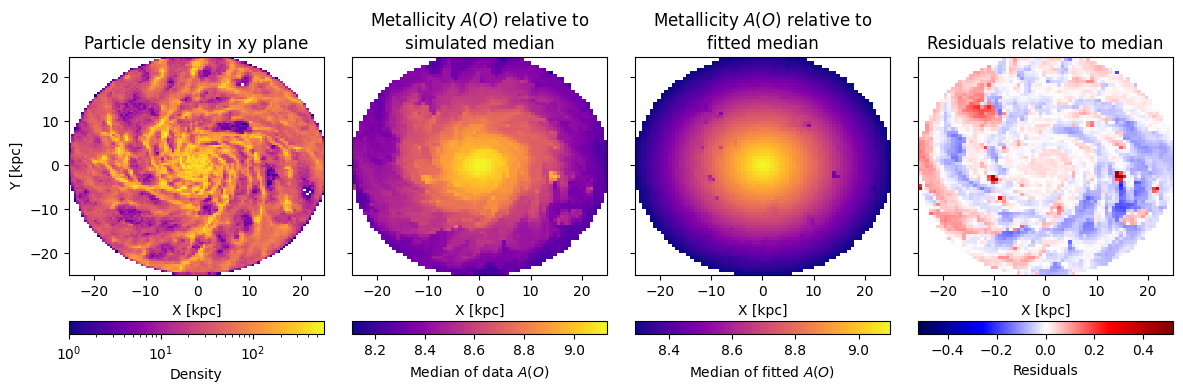

In [119]:
# plotting with a histogram instead

# gridspec = {'height_ratios': [4,1]}
fig, axs = plt.subplots(1,4, sharey=True, figsize=(12, 4))

# standard histogram
im = axs[0].hist2d(data['x'], data['y'], 
                   bins=(np.arange(min(data['x']), max(data['x']), 0.5), np.arange(min(data['y']), max(data['y']), 0.5)),
                   norm=colors.LogNorm(), cmap='plasma')
axs[0].set(xlabel = "X [kpc]", ylabel = "Y [kpc]", title="Particle density in xy plane")
plt.colorbar(im[3], ax=axs[0], label="Density", orientation='horizontal')

# median from the data
im = axs[1].imshow(binstat_med_data.T, origin='lower', aspect='auto',
                   extent=[med_data_xedges[0], med_data_xedges[-1], med_data_yedges[0], med_data_yedges[-1]],
                   cmap='plasma')
axs[1].set(title="Metallicity $A(O)$ relative to\nsimulated median", xlabel="X [kpc]")
plt.colorbar(im, ax=axs[1], label="Median of data $A(O)$", orientation='horizontal')

# median from fit
im = axs[2].imshow(binstat_median.T, origin='lower', aspect='auto',
                   extent=[median_xedges[0], median_xedges[-1], median_yedges[0], median_yedges[-1]],
                   cmap='plasma')
axs[2].set(title="Metallicity $A(O)$ relative to\nfitted median", xlabel="X [kpc]")
plt.colorbar(im, ax=axs[2], label="Median of fitted $A(O)$", orientation='horizontal')

# residual median
im = axs[3].imshow(binstat_med_resids.T, origin='lower', aspect='auto',
                   extent=[med_resids_xedges[0], med_resids_xedges[-1], med_resids_yedges[0], med_resids_yedges[-1]],
                   cmap='seismic', norm=colors.CenteredNorm())
axs[3].set(title="Residuals relative to median", xlabel="X [kpc]")
plt.colorbar(im, ax=axs[3], label="Residuals", orientation='horizontal')

# save
fig.tight_layout()
fig.savefig("figures/metallicity_xy.png")
plt.show()